In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import urllib
import os
import copy
from scipy.optimize import minimize

# Read in Beacon Data 

In [3]:
dir_path = 'ftp://data.munroelab.ca/pub/iceberg/beacon/'
dir_contents = urllib.request.urlopen(dir_path).read().splitlines()
filenames = [str(listing.split()[-1])[2:-1] for listing in dir_contents]
csv_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('csv')]
kml_filenames = [filename for filename in filenames if filename.startswith('0')
                and filename.endswith('kml')]
metadata_filename = filenames[-1]

beacon_metadata = pd.read_csv(dir_path + metadata_filename)

def get_df(data_dir_path, data_fname):
    
    df = pd.read_csv(data_dir_path + data_fname)
    df.loc[:, 'DataDate_UTC'] = pd.to_datetime(df['DataDate_UTC'])
    
    return df

df = get_df(dir_path, csv_filenames[1])

df.head()

,BeaconID,BeaconType,DataDate_UTC,TransmissionDate_UTC,Latitude,Longitude,VBatt,AT,ST,BP,Heading,Speed,LocAccuracy,MessageIndex,Satellites,GPSdelay,SNR,TTFF
0,50519,Solara,2015-04-23 18:48:37,NaN,49.22403,-51.25820,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,50519,Solara,2015-04-23 18:49:07,NaN,49.22401,-51.25817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,50519,Solara,2015-04-23 18:49:34,NaN,49.22400,-51.25809,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,50519,Solara,2015-04-23 18:49:59,NaN,49.22403,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,50519,Solara,2015-04-23 18:50:26,NaN,49.22399,-51.25789,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Simulation

In [4]:
from icedef import constants, iceberg, metocean, drift, tools

In [5]:
def get_iceberg_velocity_from_dataframe(df, start_index, end_index):
    
    dt = (df.DataDate_UTC[end_index] - df.DataDate_UTC[start_index]).total_seconds()  
    dlat = df.Latitude[end_index] - df.Latitude[start_index]
    dlon = df.Longitude[end_index] - df.Longitude[start_index]
    
    mid_lat = (df.Latitude[end_index] + df.Latitude[start_index]) / 2
    
    dy = tools.dlat_to_dy(dlat)
    dx = tools.dlon_to_dx(dlon, mid_lat)
    
    vx = dx/dt
    vy = dy/dt
    
    v = (vx, vy)
    
    return v

In [6]:
def drift_wrapper(berg_inits, meto, time_info, **kwargs):
    
    start_time, start_latitude, start_longitude, start_velocity = berg_inits
    
    berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), 
                              velocity=start_velocity)
            
    time_step, end_time = time_info
    dt = time_step.item().total_seconds()

    berg_constants = {
    'form_drag_coefficient_in_air': kwargs.pop('Ca', berg.FORM_DRAG_COEFFICIENT_IN_AIR),
    'form_drag_coefficient_in_water': kwargs.pop('Cw', berg.FORM_DRAG_COEFFICIENT_IN_WATER),
    'skin_drag_coefficient_in_air': berg.SKIN_DRAG_COEFFICIENT_IN_AIR,
    'skin_drag_coefficient_in_water': berg.SKIN_DRAG_COEFFICIENT_IN_WATER,
    'sail_area': berg.geometry.sail_area,
    'keel_area': berg.geometry.keel_area,
    'top_area': berg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': berg.geometry.mass,
    'latitude': berg.latitude
    }
        
    point = (berg.time, berg.latitude, berg.longitude)
    
    current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                        meto.interpolate(point, meto.ocean.northward_current_velocities))

    wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                     meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

    while berg.time < end_time - time_step:
        
        berg.update_history()

        ax, ay = drift.newtonian_drift((berg.eastward_velocity, berg.northward_velocity), 
                                 current_velocity, wind_velocity, 
                                 berg_constants)

        berg.time += time_step
        berg.eastward_velocity += ax * dt
        berg.northward_velocity += ay * dt
        berg.latitude += tools.dy_to_dlat(berg.northward_velocity * dt)
        berg.longitude += tools.dx_to_dlon(berg.eastward_velocity * dt, berg.latitude)

        point = (berg.time, berg.latitude, berg.longitude)

        current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                            meto.interpolate(point, meto.ocean.northward_current_velocities))

        wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                         meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

        berg_constants['latitude'] = berg.latitude
            
    return berg

In [7]:
def create_ref_berg_from_df(df, start_index, end_index):
    
    start_time = np.datetime64(df.DataDate_UTC[start_index])
    start_latitude = df.Latitude[start_index]
    start_longitude = df.Longitude[start_index]
    
    ref_berg = iceberg.quickstart(start_time, (start_latitude, start_longitude))

    for i in range(end_index - start_index + 2):

        if not df.DataDate_UTC[start_index + i] == df.DataDate_UTC[start_index + i + 1]:
            
            ref_berg.time = np.datetime64(df.DataDate_UTC[start_index + i])
            ref_berg.latitude = df.Latitude[start_index + i]
            ref_berg.longitude = df.Longitude[start_index + i]
            ref_berg.update_history()
    
    return ref_berg

Attempting to download ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150506.nc... done.
Attempting to download ftp://data.munroelab.ca/pub/ECMWF/ocean/daily/20150507.nc... done.
Attempting to download ftp://data.munroelab.ca/pub/NARR/atm/daily/20150506.nc... done.
Attempting to download ftp://data.munroelab.ca/pub/NARR/atm/daily/20150507.nc... done.


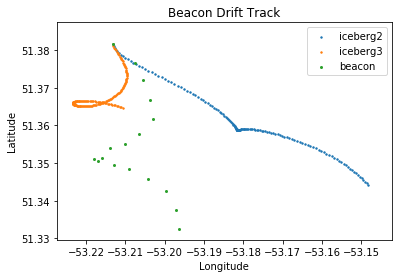

In [8]:
df = get_df(dir_path, csv_filenames[2])

start_index = 1100
end_index = 1120

ref_berg = create_ref_berg_from_df(df, start_index, end_index)

start_time = np.datetime64(df.DataDate_UTC[start_index])
end_time = np.datetime64(df.DataDate_UTC[end_index])

meto = metocean.Metocean((start_time, end_time))

start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
start_velocity = get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)

berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)

time_step = np.timedelta64(360, 's')
#dt = time_step.item().total_seconds(); #nt = int((end_time - start_time) / time_step)
time_info = (time_step, end_time)

berg2 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=3, Cw=0.1)
berg3 = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                      meto, time_info, Ca=0.1, Cw=5)

plt.scatter(berg2.history['longitude'], berg2.history['latitude'], s=2, label='iceberg2')
plt.scatter(berg3.history['longitude'], berg3.history['latitude'], s=2, label='iceberg3')

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=4, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')
plt.show()

# Optimization

In [9]:
from scipy.optimize import minimize

In [10]:
def optimization_wrapper(form_drag_coefficients, ref_berg, berg_inits, meto, time_info):
    
    Ca, Cw = form_drag_coefficients
    
    berg = drift_wrapper(berg_inits, meto, time_info, Ca=Ca, Cw=Cw)
    
    try:
        mse = tools.compute_mse((berg.longitude, berg.latitude, berg.time),
                           (ref_berg.history['longitude'], ref_berg.history['latitude'], ref_berg.history['time']),
                           ref_berg.history['time'][0] - np.timedelta64(1,'D'))
    except:
        print(berg2.time)
        raise
    
    return mse
    

In [11]:
def optimization_wrapper2(form_drag_coefficients, ref_berg, berg_inits, meto, time_info):
    
    Ca, Cw = form_drag_coefficients
    obs_vecs = (ref_berg.history['longitude'], ref_berg.history['latitude'], ref_berg.history['time'])
    reference_time = ref_berg.history['time'][0] - np.timedelta64(1,'D')
    
    berg = drift_wrapper(berg_inits, meto, time_info, Ca=Ca, Cw=Cw)
    
    mse_list = []
    
    for i in range(len(ref_berg.history['time']) - 1):
        
        j = np.where((berg.history['time'] <= ref_berg.history['time'][i + 1]))[0][-1]
        sim_point = (berg.history['longitude'][j], berg.history['latitude'][j], berg.history['time'][j])
        mse = tools.compute_mse(sim_point, obs_vecs, reference_time)
        mse_list.append(mse)
    
    mse = np.mean(np.array(mse_list))
    
    return mse

In [12]:
callback_mses = []
callback_Cas = []
callback_Cws = []

def callback(x):
    
    result = optimization_wrapper(x, ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info)
    callback_mses.append(result)
    callback_Cas.append(x[0])
    callback_Cws.append(x[1])

# Surface Optimization

In [19]:
Ca_num = 20
Cw_num = 20
Ca_lower_bound = 1; Ca_upper_bound = 5
Cw_lower_bound = 5; Cw_upper_bound = 16

scaling = 'lin'

if scaling == 'log':

    Ca_vec = np.logspace(np.log10(Ca_lower_bound), np.log10(Ca_upper_bound), num=Ca_num)
    Cw_vec = np.logspace(np.log10(Cw_lower_bound), np.log10(Cw_upper_bound), Cw_num=num)

elif scaling == 'lin':
    
    Ca_vec = np.linspace(Ca_lower_bound, Ca_upper_bound, Ca_num)
    Cw_vec = np.linspace(Cw_lower_bound, Cw_upper_bound, Cw_num)


Ca_mesh, Cw_mesh = np.meshgrid(Ca_vec, Cw_vec)

In [27]:
%%time

berg_inits = (start_time, start_latitude, start_longitude, start_velocity)

mse_matrix = np.zeros((Ca_num, Cw_num))

for i in range(Ca_num):
    for j in range(Cw_num):
        form_drag_coefficients = (Ca_mesh[i][j], Cw_mesh[i][j])
        mse_matrix[i][j] = optimization_wrapper(form_drag_coefficients, ref_berg, berg_inits, meto, time_info)
        

CPU times: user 2min, sys: 70.7 ms, total: 2min
Wall time: 2min


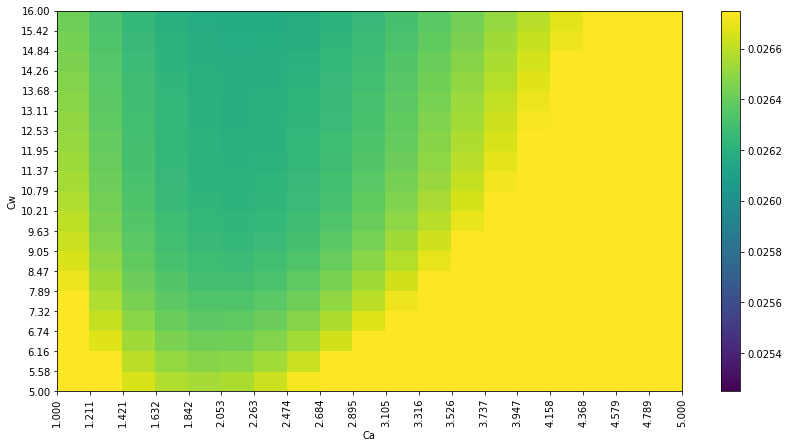

In [29]:
fig = plt.figure(figsize=(14,7))

plt.pcolormesh(Ca_vec, Cw_vec, mse_matrix, vmin=0.02525, vmax=0.02675)

plt.xticks(Ca_vec, rotation='vertical')
plt.yticks(Cw_vec)

plt.xlabel('Ca')
plt.ylabel('Cw')

plt.colorbar()

plt.show()

### Minima from brute force method

In [39]:
Ca_mesh.flatten()[np.argmin(mse_matrix.flatten())], Cw_mesh.flatten()[np.argmin(mse_matrix.flatten())]

(2.052631578947368, 16.0)

### Minima from scipy.optimize.minimize

In [41]:
optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 16), (0, 16)), 
                               args=(ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                     meto, time_info), callback=callback)
optimization_result

      fun: 0.0261872837218388
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 9.12880882e-06, -3.32893435e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 156
      nit: 19
   status: 0
  success: True
        x: array([ 1.9926969 , 14.06493582])

### How does the optimization change as we change the initial guess?

In [31]:
Ca_x0_list = [1, 7, 14]
Cw_x0_list = [1, 7, 14]

In [43]:
for Ca_x0 in Ca_x0_list:
    for Cw_x0 in Cw_x0_list:

        optimization_result = minimize(optimization_wrapper, x0=(Ca_x0, Cw_x0), 
                                       bounds=((0, 16), (0, 16)), 
                                       args=(ref_berg, 
                                             (start_time, start_latitude, start_longitude, start_velocity), 
                                             meto, time_info), 
                                       callback=callback)
        
        print(f'Initial Guess: ({Ca_x0}, {Cw_x0}), Result: {optimization_result.x}')

Initial Guess: (1, 1), Result: [ 1.9926969  14.06493582]
Initial Guess: (1, 7), Result: [ 2.05136407 11.93387646]
Initial Guess: (1, 14), Result: [ 2.09925995 14.19641443]
Initial Guess: (7, 1), Result: [ 2.16322796 16.        ]
Initial Guess: (7, 7), Result: [ 2.07338248 10.87063138]
Initial Guess: (7, 14), Result: [ 2.29269297 15.15298058]
Initial Guess: (14, 1), Result: [ 2.10557424 16.        ]
Initial Guess: (14, 7), Result: [ 2.11827577 16.        ]
Initial Guess: (14, 14), Result: [ 2.16935907 16.        ]


# Multi-step surface or minimize optimization

# Multi-step optimization

## The loop

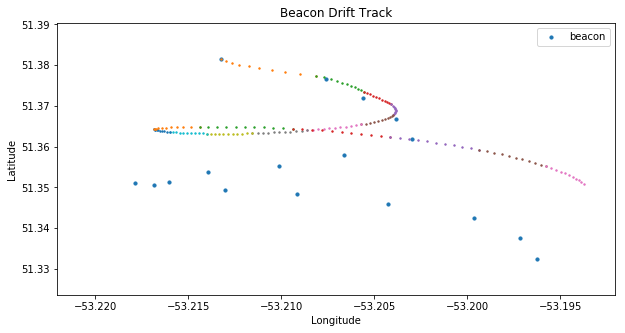

In [45]:
sub_berg_list = []
sub_ref_berg_list = []

df = get_df(dir_path, csv_filenames[2])

start_index = 1100
end_index = 1120

start_time = np.datetime64(df.DataDate_UTC[start_index])
start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
start_velocity = get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)

end_time = np.datetime64(df.DataDate_UTC[end_index])
time_step = np.timedelta64(360, 's')
time_info = (time_step, end_time)

ref_berg = iceberg.quickstart(start_time, (start_latitude, start_longitude))

for i in range(end_index - start_index + 2):
    
    if not df.DataDate_UTC[start_index + i] == df.DataDate_UTC[start_index + i + 1]:
        ref_berg.time = np.datetime64(df.DataDate_UTC[start_index + i])
        ref_berg.latitude = df.Latitude[start_index + i]
        ref_berg.longitude = df.Longitude[start_index + i]
        ref_berg.update_history()

sub_ref_berg = copy.deepcopy(ref_berg)
sub_ref_berg.history['time'] = [sub_ref_berg.history['time'][0]]
sub_ref_berg.history['latitude'] = [sub_ref_berg.history['latitude'][0]]
sub_ref_berg.history['longitude'] = [sub_ref_berg.history['longitude'][0]]

meto = metocean.Metocean((start_time, end_time))
sub_berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)
sub_berg.update_history()

for ii in range(len(ref_berg.history['time'])-1):

    start_time = sub_berg.history['time'][-1]
    start_latitude = sub_berg.history['latitude'][-1]
    start_longitude = sub_berg.history['longitude'][-1]
    start_velocity = (sub_berg.eastward_velocity, sub_berg.northward_velocity)

    del sub_ref_berg

    indxi = ii
    dindx = 1
    indxf = ii + dindx

    sub_ref_berg = copy.deepcopy(ref_berg)
    sub_ref_berg.history['time'] = sub_ref_berg.history['time'][indxi : indxf + 1]
    sub_ref_berg.history['latitude'] = sub_ref_berg.history['latitude'][indxi : indxf + 1]
    sub_ref_berg.history['longitude'] = sub_ref_berg.history['longitude'][indxi : indxf + 1]

    end_time = sub_ref_berg.history['time'][dindx]
    time_info = (time_step, end_time)

    optimization_result = minimize(optimization_wrapper, x0=(1, 1), bounds=((0, 5), (0, 5)), 
                                   args=(sub_ref_berg, (start_time, start_latitude, start_longitude, start_velocity), 
                                         meto, time_info), callback=callback)
    
    del sub_berg
    
    sub_berg = drift_wrapper((start_time, start_latitude, start_longitude, start_velocity), 
                          meto, time_info, Ca=optimization_result.x[0], Cw=optimization_result.x[1])

    sub_berg.update_history()

    sub_berg_list.append(sub_berg)
    sub_ref_berg_list.append(ref_berg)

fig = plt.figure(figsize=(10,5))

plt.scatter(ref_berg.history['longitude'], ref_berg.history['latitude'], s=10, label='beacon')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Beacon Drift Track')

for berg in sub_berg_list:
    
    plt.scatter(berg.history['longitude'], berg.history['latitude'], s=2)


# Overlay currents and winds plot

In [46]:
df = get_df(dir_path, csv_filenames[2])

start_index = 1100
end_index = 1120

ref_berg = create_ref_berg_from_df(df, start_index, end_index)

start_time = np.datetime64(df.DataDate_UTC[start_index])
end_time = np.datetime64(df.DataDate_UTC[end_index])

meto = metocean.Metocean((start_time, end_time))

start_latitude = df.Latitude[start_index]
start_longitude = df.Longitude[start_index]
start_velocity = get_iceberg_velocity_from_dataframe(df, start_index, start_index + 10)

#berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), velocity=start_velocity)
berg_inits = (start_time, start_latitude, start_longitude, start_velocity)

time_step = np.timedelta64(360, 's')
#dt = time_step.item().total_seconds(); #nt = int((end_time - start_time) / time_step)
time_info = (time_step, end_time)

In [47]:
def drift_wrapper2(berg_inits, meto, time_info, **kwargs):
    
    start_time, start_latitude, start_longitude, start_velocity = berg_inits
    
    berg = iceberg.quickstart(start_time, (start_latitude, start_longitude), 
                              velocity=start_velocity)
            
    time_step, end_time = time_info
    dt = time_step.item().total_seconds()

    berg_constants = {
    'form_drag_coefficient_in_air': kwargs.pop('Ca', berg.FORM_DRAG_COEFFICIENT_IN_AIR),
    'form_drag_coefficient_in_water': kwargs.pop('Cw', berg.FORM_DRAG_COEFFICIENT_IN_WATER),
    'skin_drag_coefficient_in_air': berg.SKIN_DRAG_COEFFICIENT_IN_AIR,
    'skin_drag_coefficient_in_water': berg.SKIN_DRAG_COEFFICIENT_IN_WATER,
    'sail_area': berg.geometry.sail_area,
    'keel_area': berg.geometry.keel_area,
    'top_area': berg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': berg.geometry.mass,
    'latitude': berg.latitude
    }
        
    point = (berg.time, berg.latitude, berg.longitude)
    
    current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                        meto.interpolate(point, meto.ocean.northward_current_velocities))

    wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                     meto.interpolate(point, meto.atmosphere.northward_wind_velocities))
    
    current_velocity_history = [current_velocity]
    wind_velocity_history = [wind_velocity]

    while berg.time < end_time - time_step:
        
        berg.update_history()

        ax, ay = drift.newtonian_drift((berg.eastward_velocity, berg.northward_velocity), 
                                 current_velocity, wind_velocity, 
                                 berg_constants)

        berg.time += time_step
        berg.eastward_velocity += ax * dt
        berg.northward_velocity += ay * dt
        berg.latitude += tools.dy_to_dlat(berg.northward_velocity * dt)
        berg.longitude += tools.dx_to_dlon(berg.eastward_velocity * dt, berg.latitude)

        point = (berg.time, berg.latitude, berg.longitude)

        current_velocity = (meto.interpolate(point, meto.ocean.eastward_current_velocities),
                            meto.interpolate(point, meto.ocean.northward_current_velocities))

        wind_velocity = (meto.interpolate(point, meto.atmosphere.eastward_wind_velocities),
                         meto.interpolate(point, meto.atmosphere.northward_wind_velocities))

        current_velocity_history.append(current_velocity)
        wind_velocity_history.append(wind_velocity)
        
        berg_constants['latitude'] = berg.latitude
        
    berg.update_history()
            
    return berg, current_velocity_history, wind_velocity_history

In [48]:
berg, current_velocity_history, wind_velocity_history = drift_wrapper2(berg_inits, meto, time_info)

In [49]:
current_u = [u for u,v in current_velocity_history]
current_v = [v for u,v in current_velocity_history]
current_magnitude = [np.sqrt(u**2 + v**2) for u,v in current_velocity_history]
wind_u = [u for u,v in wind_velocity_history]
wind_v = [v for u,v in wind_velocity_history]
wind_magnitude = [np.sqrt(u**2 + v**2) for u,v in wind_velocity_history]
berg_lons = berg.history['longitude']
berg_lats = berg.history['latitude']
ref_berg_lons = ref_berg.history['longitude']
ref_berg_lats = ref_berg.history['latitude']

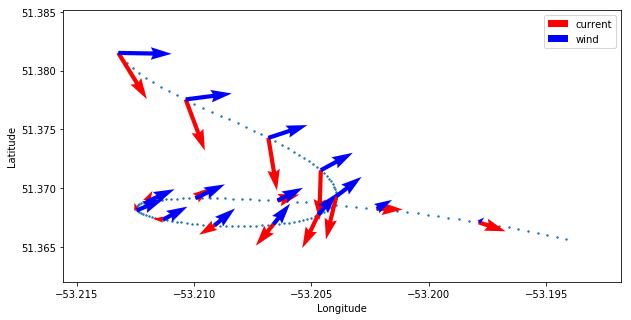

In [51]:
fig = plt.figure(figsize=(10,5))

plt.scatter(berg_lons, berg_lats, s=2)
#plt.scatter(ref_berg_lons, ref_berg_lats, marker='x', c='black')

plt.quiver(berg_lons[::10], berg_lats[::10], current_u[::10], current_v[::10], color='red', label='current')
plt.quiver(berg_lons[::10], berg_lats[::10], wind_u[::10], wind_v[::10], color='blue', label='wind')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.show()